In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [81]:
#load the mnist dataset
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

In [82]:
#create train and test loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

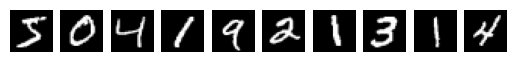

In [83]:
#visualize the dataset
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(mnist_train[i][0].squeeze().numpy(), cmap='gray')
    ax[i].axis('off')

In [84]:
#create a cnn architecture
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [85]:
#create the model
model = MNIST_CNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [86]:
def train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, CUDA=False, print_accs=True):

    traing_accs = []
    test_accs = []

    for epoch in range(1, num_epochs+1):
        
        model.train()
        # Write training loop here
        for i, (X, y) in enumerate(train_dataloader):
            
            if CUDA:
                X = X.cuda()
                y = y.cuda()

            optimizer.zero_grad()
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()

        # Write evaluation loop(s) here
        
        # Calculate training accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in train_dataloader:
                if CUDA:
                    X = X.cuda()
                    y = y.cuda()

                y_pred = model(X)
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Training Accuracy: {correct / total}")
        traing_accs.append(correct / total)
        
        # Calculate test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_dataloader:
                if CUDA:
                    X = X.cuda()
                    y = y.cuda()

                y_pred = model(X)
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Accuracy: {correct / total}")
        if print_accs:
            print(f"Epoch {epoch}, Training Accuracy: {traing_accs[-1]}, Validation Accuracy: {correct / total}")
        
        test_accs.append(correct / total)
        # Do not forget to use model.train() and model.eval() before training and evaluation loops respectively.
    return traing_accs, test_accs
    

In [87]:
#train the model
traing_accs, test_accs = train_model(model, train_loader, test_loader, optimizer, criterion, 5)

Epoch 1, Training Accuracy: 0.9672166666666666, Validation Accuracy: 0.9697
Epoch 2, Training Accuracy: 0.9802166666666666, Validation Accuracy: 0.9798
Epoch 3, Training Accuracy: 0.97905, Validation Accuracy: 0.9782
Epoch 4, Training Accuracy: 0.9786666666666667, Validation Accuracy: 0.9782
Epoch 5, Training Accuracy: 0.9824833333333334, Validation Accuracy: 0.9811


In [88]:
def create_fgsm_adversarial_example(model, X, y, epsilon):
    X.requires_grad = True
    model.zero_grad()
    output = model(X)
    model_prediction_unperturbed = output.argmax(dim=1)
    prediction_confidence = F.softmax(output, dim=1).max()
    loss = criterion(output, y)
    loss.backward()
    x_grad = X.grad.data
    x_adv = X + epsilon * x_grad.sign()
    return model_prediction_unperturbed, prediction_confidence, x_adv

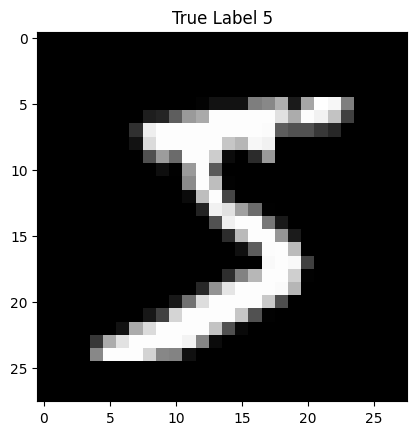

In [89]:
#get the first example of mnist dataset and print them
X, y = mnist_train[0]
#plot the image with the label
plt.imshow(X.squeeze().numpy(), cmap='gray')
plt.title(f"True Label {y}")
plt.show()

In [90]:
#convert y to tensor
y = torch.tensor([y])

In [91]:
#create an adversarial example using fgsm attack
model_pred_unperturbed, prediction_confidence, perturbed_img = create_fgsm_adversarial_example(model, X, y, 0.1)
print(f"Model Prediction on Unperturbed Image: {model_pred_unperturbed.item()} with confidence {prediction_confidence.item()}")


Model Prediction on Unperturbed Image: 5 with confidence 0.8140393495559692


In [92]:
#get the prediction of the model on the perturbed image
model_pred_perturbed = model(perturbed_img.unsqueeze(0))
prediction_confidence = F.softmax(model_pred_perturbed, dim=1).max().item()
model_pred_perturbed = model_pred_perturbed.argmax(dim=1)

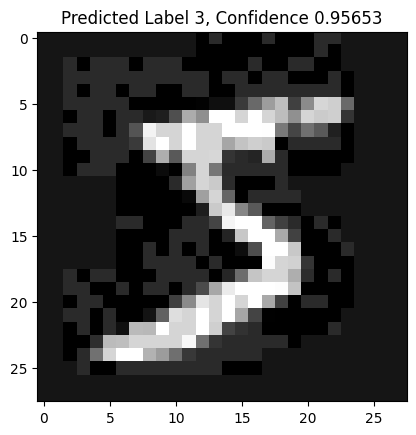

In [93]:
#plot the perturbed image
plt.imshow(perturbed_img.squeeze().detach().numpy(), cmap='gray')
plt.title(f"Predicted Label {model_pred_perturbed.item()}, Confidence {prediction_confidence:.5f}")
plt.show()

### We can see that the perturbed image has some additional noise but is still recognizeable as a 5. However, the model classifies the image as a 3 with extremely high predicted probability. This is a clear example of an adversarial attack.